<a href="https://colab.research.google.com/github/biedun/JEPSis/blob/main/Brats_segmentation_preprocess_data_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Nifti data and convert to numpy
## Data file organization

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



* /naomi/DATA/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1
```
BraTS19_TCIA04_192_1_flair.nii.gz  
BraTS19_TCIA04_192_1_t1.nii.gz    
BraTS19_TCIA04_192_1_t2.nii.gz
BraTS19_TCIA04_192_1_seg.nii.gz    
BraTS19_TCIA04_192_1_t1ce.nii.gz
```

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema
* Label 4: enhancing tumor

In [232]:
DATA= '/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/'
#VALIDATION_DATA = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'HGG/'
DATA_LGG = DATA + 'LGG/'

NUMPY_DIR = '/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/numpy_images/'
#VALIDATION_NUMPY_DIR = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [217]:
DATA_HGG

'/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_TrainingHGG/'

In [218]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [219]:
import os, sys, glob
import numpy as np
#import SimpleITK as sitk
import nibabel as nib
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [220]:
import pandas as pd
import numpy as np

In [221]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

In [222]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

## Visualization utils

In [223]:
#load Naomis visualisation script for highlighting the classes
from importlib import reload  # Python 3.4+ only.
py_file_location = "/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/"
sys.path.insert(0, py_file_location)
%cd /content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5
%pwd
import visualization_utils  as vu
#reload(vu)

/content/drive/.shortcut-targets-by-id/1XrC40LeU9YA-mbLjmQ_7MvZ22JV3JECl/JEPSis/Tumor_Data/Subject1till5


In [224]:
def show_img_lable(img, lbl, modality = 0):

    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);


## Data utilities

In [226]:
def read_img_nib(img):
    inputImage = nib.load(img) # load image in nifti file
    inputImage = inputImage.get_fdata() # get data from image
    reshaped_image = inputImage.transpose((2, 1, 0)) # reshape from (240,240,155) to (155,240,240)
    image = reshaped_image.astype('float32')
    return image

In [227]:
# ima files are of the form
# BraTS19_TCIA04_192_1_flair.nii
# BraTS19_TCIA04_192_1_t1.nii
# BraTS19_TCIA04_192_1_t2.nii
# BraTS19_TCIA04_192_1_seg.nii
# BraTS19_TCIA04_192_1_t1ce.nii

def read_image_into_numpy(dirpath):

    img_id = os.path.basename(dirpath) # get last item of path of the image = patients directory
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32) # create an array of zeros in image shape

    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii') # create path till image files, here only for flair.nii
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_nib(flair_img) # convert to array by function, which was created previously

    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_nib(t1_img)
    else:
        np_image[1] = read_img_nib(t1_nb4_img)

    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_nib(t1ce_img)
    else:
        np_image[2] = read_img_nib(t1ce_nb4_img)


    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_nib(t2_img)

    return np_image

In [228]:
def read_lable_into_numpy(dirpath):
    # get last item of path = patients directory
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((155, 240, 240), dtype=np.int64)

    ## lable
    # crucial that patients directories and files have same naming,
    # get whole path till directory+img_id(=patients directory)+ending
    lable_img = os.path.join(dirpath, img_id+'_seg.nii')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_nib(lable_img).astype(int)

    return np_image

## Load data and Collect train data info

In [233]:
# get a list of all paths depending on the grade
hgg_paths = []
for item in os.listdir(DATA_HGG):
  path = DATA_HGG+item
  hgg_paths.append(path)

lgg_paths = []
for item in os.listdir(DATA_LGG):
  path_lgg = DATA_LGG+item
  lgg_paths.append(path_lgg)

In [234]:
len(lgg_paths),len(hgg_paths)#,len(val_paths)

(76, 259)

In [194]:
#lgg_paths

['/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/BraTS19_2013_16_1',
 '/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/BraTS20_Training_262',
 '/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/BraTS20_Training_299',
 '/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/BraTS19_TCIA10_346_1',
 '/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/Brats18_2013_16_1',
 '/content/drive/MyDrive/JEPSis/Tumor_Data/Subject1till5/LGG/Brats18_TCIA10_346_1']

In [236]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2)) # for row-wise coordinates
    c = np.any(img, axis=(0, 2)) # for column-wise coordinates
    z = np.any(img, axis=(0, 1)) # for depth-wise coordinates

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

### View some data

In [243]:
np_img = read_image_into_numpy('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_7_1')

In [241]:
def show_img_lable(img, lbl, modality = 0):

    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);

<Figure size 600x500 with 0 Axes>

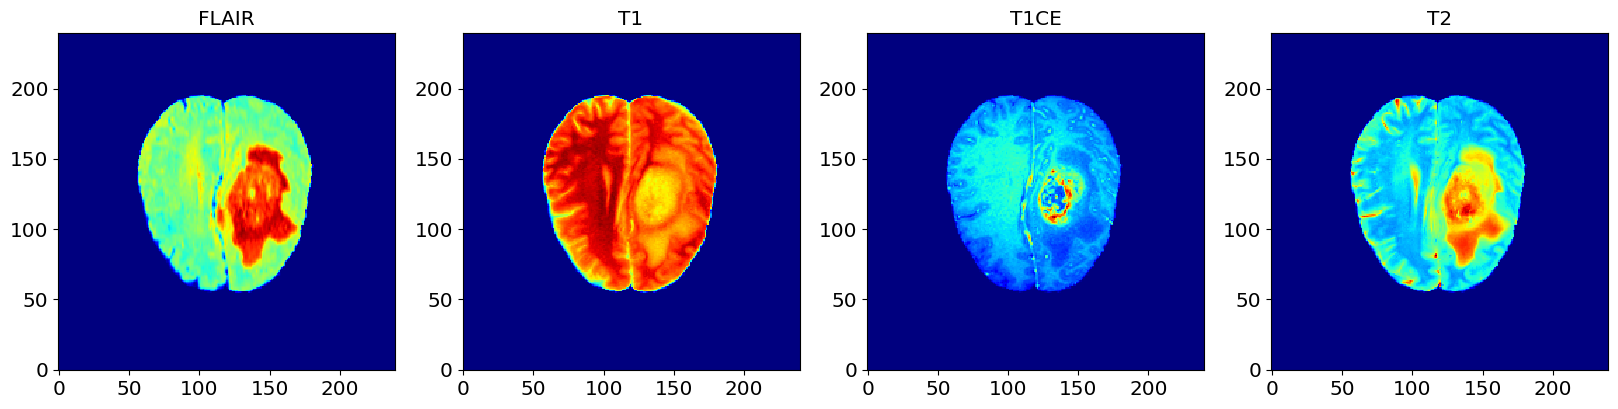

In [244]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)

In [246]:
np_lbl = read_lable_into_numpy('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_7_1')

<Figure size 600x500 with 0 Axes>

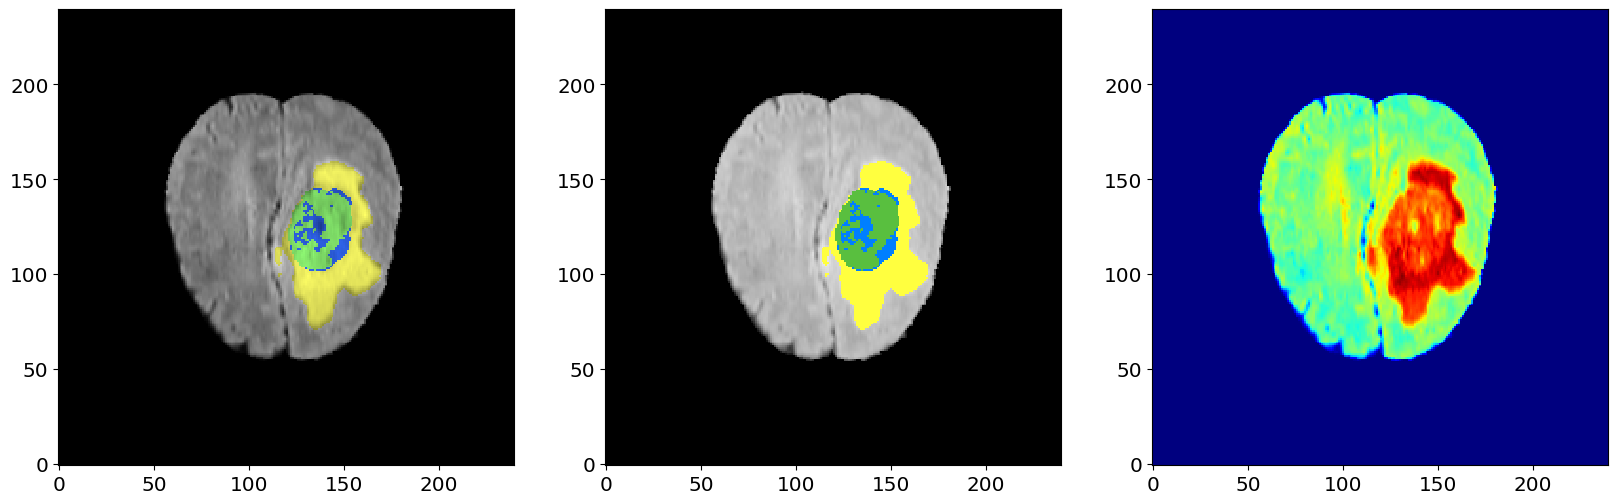

In [247]:
img1 = vu.show_lable_on_image4(np_img[0,100,:, :], np_lbl[100])
img2 = vu.show_lable_on_image(np_img[0,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2, np_img[0,100]])

### Read all images collect data and save as numpy

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

Label 0: background
Label 1: necrotic and non-enhancing tumor
Label 2: edema
Label 4: enhancing tumor
In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:

(155, 240, 240, 4) For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

> Lables are 1, 2 and 4.
So we will save 4 as 3.
#### Dont forget to set it back to 4 prior submission to Brats.



In [248]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [249]:
df = pd.DataFrame(columns=['Grade','id','lab0','lab1','lab2','lab3',
                           'rmin','rmax','cmin','cmax','zmin','zmax'])

In [254]:
def fill_df_from_path(df, paths = hgg_paths, grade='HGG'):

    for f in paths:
        np_img = read_image_into_numpy(f)
        np_lbl = read_lable_into_numpy(f)
        assert(np_lbl[np_lbl==3].sum()==0) # make sure there is no class 3
        np_lbl = np.where(np_lbl==4, 3, np_lbl) # assign 3 to class 4


        new_img = np.zeros((155, 240, 240,4)) # create an array of zeros in image shape
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] # change position of label class

        #nimg = os.path.join(NUMPY_DIR,  os.path.basename(f)+'.npy') #create path
        #np.save(nimg, new_img) # save file in numpy_images directory for changed image
        #nlbl = os.path.join(NUMPY_DIR,  os.path.basename(f)+'_lbl.npy') #create path
        #np.save(nlbl, np_lbl) # save file for new label in same directory

        # get labels and their associated pixels (=repeats)
        lbls, repeats = np.unique(np_lbl, return_counts=True)
        lbl_counts=[0,0,0,0] # initiate a list for the 4 classes to add repeats
        for i in range(len(repeats)):
            lbl_counts[lbls[i]] = repeats[i]

        # create a list of all values belonging to one row for the df
        vals = [grade] + [os.path.basename(f)] + lbl_counts + bbox2_3D(np_lbl)
        # assign the vals list to the index of the row of the current df length
        df.loc[len(df)] = vals

    return df



In [255]:
df = fill_df_from_path(df, paths = lgg_paths, grade='LGG')
df = fill_df_from_path(df, paths = hgg_paths)

In [256]:
df[['lab' +str(i) for i in range(1,4)]].sum()

lab1    10617168
lab2    22064304
lab3     6554906
dtype: int64

In [ ]:
6260157.0*100/(7566423.0+19290531.0+6260157.0)

18.903089100978644

<Axes: title={'center': 'Lable distribution'}>

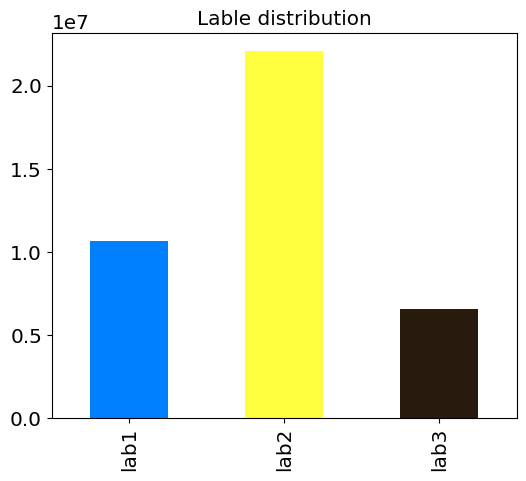

In [257]:
df[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution')

### Process validation data

In [ ]:
df_val = pd.DataFrame(columns=['id','lab0','lab1','lab2','lab3'])

In [ ]:
def fill_df_from_path(df=df_val, paths = val_paths):

    for f in paths:
        np_img = read_image_into_numpy(f)

        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:]

        nimg = os.path.join(VALIDATION_NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)

        vals = [os.path.basename(f)]+[0,0,0,0]
        df.loc[len(df)] = vals

    return df



In [ ]:
df_val = fill_df_from_path(df_val, paths = val_paths)

## Split data to train-test and save

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

In [258]:
df.to_csv('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training/df_from_2019_images.csv', index=False)
#df_test.to_csv('df_test.csv',index=False)
#df_val.to_csv('df_val.csv' ,index=False)